# Analisis exploratorio - Premier League

## Carga de datos

Para cargar el dataset se utiliza la clase `CargadorDatos` la cual recibe como parametro el dataframe a leer

In [1]:
import sys
import os
ruta_src = os.path.abspath(os.path.join('..', 'src'))# <== Cambiar la ruta para leer archivos importados
sys.path.append(ruta_src)

from cargaDatos.cargador_datos import CargadorDatos
import pandas as pd

df = pd.read_csv('../src/data/raw/premier.csv')
datos = CargadorDatos(df)
datos.dataFrame.head(3)

,Player,Team,#,Nation,Position,Age,Minutes,Goals,Assists,Penalty Shoot on Goal,...,Goal-Creating Actions,Passes Completed,Passes Attempted,Pass Completion %,Progressive Passes,Carries,Progressive Carries,Dribble Attempts,Successful Dribbles,Date
0,Bruno Fernandes,Manchester United,8,POR,"FW,AM",29-343,90.0,0,0,0,...,0,43,60,"71,7",6,50,7,1,1,2024-08-16
1,Marcus Rashford,Manchester United,10,ENG,LW,26-290,90.0,0,0,0,...,0,22,30,"73,3",2,34,2,6,0,2024-08-16
2,Amad Diallo,Manchester United,16,CIV,RW,22-036,NaN,0,0,0,...,0,28,33,"84,8",1,22,0,1,1,2024-08-16


El dataset contiene +4000 filas y 33 columnas acerca del rendimiento de jugadores de la Premier League. Contiene informacion como El nombre del jugador, su equipo, posicion,edad, minutos jugados, entre otros.

In [2]:
print(datos.num_filas , datos.num_columnas)

4270 33


Si se accede a la propiedad `porcentaje_nulos` se aprecia como tanto la columna 'minutes' como 'Pass Completion %' poseen valores nulos

In [3]:
datos.porcentaje_nulos

Minutes              0.14
Pass Completion %    1.08
dtype: float64

## EDA

### Limpieza

Para realizar el analisis exploratorio, se  utiliza la clase `ProcesadorEDA` la cual recibe como parametro el dataframe a analizar. Mediante el atributo `ver_tipos` se muestran los nombres de las variables segun su tipo.

In [4]:
from eda.procesador_eda import ProcesadorEDA

eda = ProcesadorEDA(df)
eda.ver_tipos['textual']

['Player', 'Team', 'Nation', 'Position', 'Age', 'Pass Completion %', 'Date']

Se aprecia como muchas columnas estan erroneamente asignadas como tipo textual. Para solucionarlo, primero hay que normalizar el texto. Mediante el metodo `normalizar_col_str` se le indica por parametros cuales columnas se desean modificar.

In [5]:
eda.normalizar_col_str(columnas= ['Player', 'Team', 'Nation'])

 Opcionalmente se puede usar el parametro `regex` el cual permite sobreescribir la expresion regular aplicada por defecto:

In [6]:
eda.normalizar_col_str(columnas=["Position"], regex=r"[^A-ZÁÉÍÓÚÜÑ0-9\s,]") # No se eliminan las comas ',' ya que separan las posiciones de los jugadores


Una vez que las variables esten limpias se deben convertir al tipo correcto. Para ello hemos creado distintos metodos segun el tipo deseado:

In [7]:
eda.convertir_a_categoria(['Team', 'Nation', 'Position', 'Player'])

eda.convertir_a_numero(['Age'], eliminar = r'-.*$') # elimnina todo lo que esta despues del guion
eda.convertir_a_numero(['Pass Completion %'], reemplazar=[',','.'])

eda.convertir_a_fecha(['Date'])

Dando como resultado las variables con su tipo correcto:

In [8]:
eda.ver_tipos

{'numericas': ['#',
  'Age',
  'Minutes',
  'Goals',
  'Assists',
  'Penalty Shoot on Goal',
  'Penalty Shoot',
  'Total Shoot',
  'Shoot on Target',
  'Yellow Cards',
  'Red Cards',
  'Touches',
  'Dribbles',
  'Tackles',
  'Blocks',
  'Expected Goals (xG)',
  'Non-Penalty xG (npxG)',
  'Expected Assists (xAG)',
  'Shot-Creating Actions',
  'Goal-Creating Actions',
  'Passes Completed',
  'Passes Attempted',
  'Pass Completion %',
  'Progressive Passes',
  'Carries',
  'Progressive Carries',
  'Dribble Attempts',
  'Successful Dribbles'],
 'textual': [],
 'categoria': ['Player', 'Team', 'Nation', 'Position'],
 'fechas': ['Date'],
 'booleanos': []}

Para resumir el dataset, es posible combinar algunas columnas como un porcentaje calculado. Por ejemplo, las columnas de penales acertados y penales intentados se pueden resumir en una que se llame 'Porcentaje de penales acertados':

In [9]:
eda.calc_porcentaje(dividendo='Penalty Shoot on Goal', divisor='Penalty Shoot', col_nombre='Penales acertados %')
eda.calc_porcentaje(dividendo='Shoot on Target', divisor='Total Shoot', col_nombre='Tiros acertados %')
eda.calc_porcentaje(dividendo='Successful Dribbles', divisor='Dribble Attempts', col_nombre='Dribbles exitosos %')
eda.calc_porcentaje(dividendo='Progressive Carries', divisor='Carries', col_nombre='Carries progresivos %')

Ahora hay que eliminar las columnas que no aportan mucho valor al dataset, como por ejemplo el numero de camiseta del jugador o aquellas columnas que se calculan a partir de otras, como lo son el porcentaje de pases completados. De esta manera se evita redundancia y se facilita la lectura de la informacion

In [10]:
eda.eliminar_cols(columnas= ['#', 'Passes Completed', 'Passes Attempted', 'Penalty Shoot on Goal', 'Penalty Shoot', 'Shoot on Target', 'Total Shoot', 'Dribble Attempts', 'Successful Dribbles', 'Carries', 'Progressive Carries', 'Dribbles'])

### Nulos

Como se menciono anteriormente, las columnas de 'minutos' y 'pases completados' poseen valores nulos. Para decidir que hacer con ellos primero hay que analizar las columnas

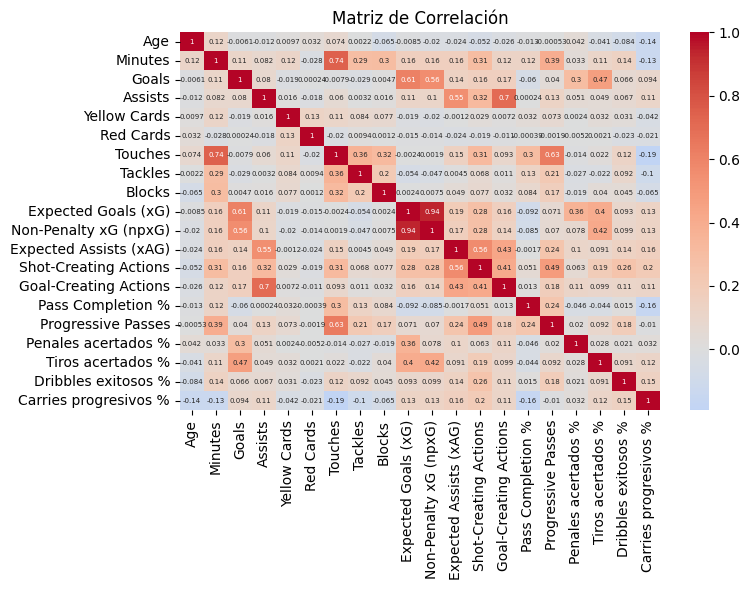

In [11]:
eda.matriz_correlacion()

La matriz de correlacion muestra como la variable de minutos tiene una fuerte correlacion positiva con los toques que el jugador le daba al balon, tambien tiene otra importante relacion con la cantidad de carreras que el jugador hacia con el balon. Esto significa que si alguna de esas variables aumenta, las otras tambien lo hacen en proporcion. 

Debido a esa correlacion, se puede considerar realizar una regresion lineal multiple para imputar los datos nulos en la variable de minutos, sin embargo esto no se podria realizar con la variable de porcentaje de pases completados, ya que no posee ninguna correlacion relevante.

Para considerar otros metodos de imputacion, es necesario ver el resumen descriptivo:

In [12]:
eda.resumen_descriptivo

,Age,Minutes,Goals,Assists,Yellow Cards,Red Cards,Touches,Tackles,Blocks,Expected Goals (xG),...,Expected Assists (xAG),Shot-Creating Actions,Goal-Creating Actions,Pass Completion %,Progressive Passes,Date,Penales acertados %,Tiros acertados %,Dribbles exitosos %,Carries progresivos %
count,4270.000000,4264.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,4270.000000,...,4270.000000,4270.000000,4270.000000,4224.000000,4270.000000,4270,4270.000000,4270.000000,4270.000000,4270.000000
mean,26.000703,64.791510,0.094145,0.071194,0.161593,0.004918,39.362763,0.548478,0.744496,0.097635,...,0.072482,1.548946,0.166276,78.115033,2.456206,2024-10-11 23:28:17.985948416,0.538642,15.405293,22.896698,6.687705
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2024-08-16 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,23.000000,34.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,71.000000,0.000000,2024-09-14 00:00:00,0.000000,0.000000,0.000000,0.000000
50%,26.000000,82.500000,0.000000,0.000000,0.000000,0.000000,38.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,80.800000,2.000000,2024-10-06 00:00:00,0.000000,0.000000,0.000000,2.500000
75%,28.000000,90.000000,0.000000,0.000000,0.000000,0.000000,56.000000,1.000000,1.000000,0.100000,...,0.100000,2.000000,0.000000,88.500000,4.000000,2024-11-09 00:00:00,0.000000,0.000000,50.000000,10.000000
max,39.000000,90.000000,4.000000,3.000000,2.000000,1.000000,144.000000,7.000000,7.000000,2.400000,...,1.600000,16.000000,6.000000,100.000000,30.000000,2024-12-05 00:00:00,100.000000,100.000000,100.000000,100.000000
std,3.923818,31.249166,0.326883,0.271362,0.373803,0.069964,25.091461,0.886571,1.026271,0.217993,...,0.167391,1.856990,0.458118,15.479876,2.745780,NaN,7.320286,31.617955,36.126057,10.464246


Considerando el tipo de valor de cada variable, se puede ver como ambas poseen una desviacion estandar muy alta, por lo que el uso del promedio no es una buena opcion para imputar los datos.

Debido a que los valores nulos son una cantidad muy pequeña estos registros se podrian eliminar. Pero para mantener la distribucion de los datos y evitar perder informacion, los valores nulos se imputaran usando la mediana:

In [13]:
eda.cambiar_nulos(metodo='mediana', columnas=['Minutes', 'Pass Completion %'])

Dando como resultado final:

In [16]:
eda.dataFrame.head()
#eda.dataFrame.to_csv("../src/data/processed/premier_clean.csv", index=False)

,Player,Team,Nation,Position,Age,Minutes,Goals,Assists,Yellow Cards,Red Cards,...,Expected Assists (xAG),Shot-Creating Actions,Goal-Creating Actions,Pass Completion %,Progressive Passes,Date,Penales acertados %,Tiros acertados %,Dribbles exitosos %,Carries progresivos %
0,BRUNO FERNANDES,MANCHESTER UNITED,POR,"FW,AM",29,90.0,0,0,0,0,...,0.0,2,0,71.7,6,2024-08-16,0.0,50.0,100.0,14.0
1,MARCUS RASHFORD,MANCHESTER UNITED,ENG,LW,26,90.0,0,0,0,0,...,0.7,1,0,73.3,2,2024-08-16,0.0,0.0,0.0,5.9
2,AMAD DIALLO,MANCHESTER UNITED,CIV,RW,22,82.5,0,0,0,0,...,0.1,1,0,84.8,1,2024-08-16,0.0,0.0,100.0,0.0
3,ALEJANDRO GARNACHO,MANCHESTER UNITED,ARG,RW,20,30.0,0,1,0,0,...,0.2,3,1,90.9,0,2024-08-16,0.0,0.0,0.0,18.2
4,MASON MOUNT,MANCHESTER UNITED,ENG,AM,25,60.0,0,0,1,0,...,0.1,3,0,73.3,1,2024-08-16,0.0,100.0,0.0,0.0
